In [1]:
# --- Bloco 1 (Revisado e Corrigido): Carga Completa de Dados (com Atributos Válidos) ---

import pandas as pd
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'
print("Projeto de Análise de Fitoplâncton iniciado.")
print("Configurações visuais (Fonte Arial) aplicadas.")

subpasta_grupo = 'fitoplancton'
caminho_saida_grupo = os.path.join('..', '03_relatorios', subpasta_grupo)
os.makedirs(caminho_saida_grupo, exist_ok=True)
print(f"Pasta de saída para os relatórios foi definida e verificada em: '{caminho_saida_grupo}'")

df_fito_bruto = pd.DataFrame()

try:
    print("\n[1/2] Conectando ao banco de dados...")
    load_dotenv()
    db_user = os.getenv('DB_USER'); db_password = os.getenv('DB_PASSWORD')
    db_host = os.getenv('DB_HOST'); db_name = os.getenv('DB_NAME')

    if not all([db_user, db_password, db_host, db_name]):
        raise ValueError("Credenciais do banco de dados não encontradas.")

    db_url = f"postgresql://{db_user}:{db_password}@{db_host}:5432/{db_name}"
    engine = create_engine(db_url)

    # <<-- CORREÇÃO AQUI: A coluna 'endemismo' foi removida da query -->>
    query = text("""
        SELECT
            t1.nome_campanha, t1.nome_ponto, t1.nome_cientifico,
            t1.contagem, t1.tipo_amostragem,
            t2.filo, t2.habito_alimentar, t2.valor_economico,
            t2.status_ameaca_nacional, t2.status_ameaca_global
        FROM
            public.biota_analise_consolidada AS t1
        LEFT JOIN
            public.especies AS t2 ON t1.nome_cientifico = t2.nome_cientifico
        WHERE
            t1.grupo_biologico = :grupo
    """)

    with engine.connect() as connection:
        df_fito_bruto = pd.read_sql_query(query, connection, params={'grupo': 'Fitoplâncton'})
    
    print("   -> Conexão bem-sucedida. Dados brutos (com atributos válidos) carregados.")
    print(f"   -> Total de registros de Fitoplâncton encontrados: {len(df_fito_bruto)}")

except (ValueError, SQLAlchemyError) as e:
    print(f"   -> ERRO DURANTE A CARGA DE DADOS: {e}")

if not df_fito_bruto.empty:
    print("\n[2/2] Iniciando limpeza e padronização dos dados...")
    df_fito_limpo = df_fito_bruto.copy()
    mapa_nomes = {'nome_campanha': 'campanha', 'nome_ponto': 'ponto_amostral', 'contagem': 'densidade'}
    df_fito_limpo.rename(columns=mapa_nomes, inplace=True)
    df_fito_limpo['campanha'] = df_fito_limpo['campanha'].str.replace('º', '', regex=False).str.replace('ª', '', regex=False)
    df_fito_limpo.dropna(subset=['nome_cientifico'], inplace=True)
    print("\n--- Processo de Carga e Limpeza Concluído ---")
    print("O DataFrame 'df_fito_limpo' está pronto para as análises.")
    display(df_fito_limpo.head())
else:
    print("\n--- AVISO: Nenhum dado de Fitoplâncton foi carregado. ---")

Projeto de Análise de Fitoplâncton iniciado.
Configurações visuais (Fonte Arial) aplicadas.
Pasta de saída para os relatórios foi definida e verificada em: '..\03_relatorios\fitoplancton'

[1/2] Conectando ao banco de dados...
   -> Conexão bem-sucedida. Dados brutos (com atributos válidos) carregados.
   -> Total de registros de Fitoplâncton encontrados: 268

[2/2] Iniciando limpeza e padronização dos dados...

--- Processo de Carga e Limpeza Concluído ---
O DataFrame 'df_fito_limpo' está pronto para as análises.


,campanha,ponto_amostral,nome_cientifico,densidade,tipo_amostragem,filo,habito_alimentar,valor_economico,status_ameaca_nacional,status_ameaca_global
0,1 Campanha (Chuva),AQ05,Penium sp.,1.0,Qualitativo,CHAROPHYTA,None,None,None,None
1,1 Campanha (Chuva),AQ05,Achnanthidium minutissimum,1.0,Qualitativo,BACILLARIOPHYTA,None,None,None,None
2,1 Campanha (Chuva),AQ01,Brachysira subrostrata,1.0,Qualitativo,BACILLARIOPHYTA,None,None,None,None
3,1 Campanha (Chuva),AQ05,Brachysira subrostrata,1.0,Qualitativo,BACILLARIOPHYTA,None,None,None,None
4,1 Campanha (Chuva),AQ05,Cymbopleura naviculiformis,1.0,Qualitativo,BACILLARIOPHYTA,None,None,None,None


In [2]:
# --- Bloco 2 (Corrigido Final): Tabela de Composição de Espécies Completa ---

import numpy as np

print("Iniciando a criação da Tabela de Composição de Espécies completa...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")
else:
    df_especies_fito = df_fito_limpo.dropna(subset=['nome_cientifico']).copy()
    
    # 1. LISTA DE ESPÉCIES E TODOS OS SEUS ATRIBUTOS
    colunas_atributos = [
        'filo', 'nome_cientifico', 'habito_alimentar', 'valor_economico',
        'status_ameaca_nacional', 'status_ameaca_global'
    ]
    tabela_atributos = df_especies_fito[colunas_atributos].drop_duplicates(subset=['nome_cientifico']).copy()
    
    cols_para_preencher = [
        'filo', 'habito_alimentar', 'valor_economico',
        'status_ameaca_nacional', 'status_ameaca_global'
    ]
    tabela_atributos[cols_para_preencher] = tabela_atributos[cols_para_preencher].fillna('-')
    
    print("   -> Lista de espécies e todos os atributos criada e limpa.")

    # 2. OCORRÊNCIA POR CAMPANHA
    campanhas_unicas = sorted(df_especies_fito['campanha'].unique())
    mapa_campanhas = {nome: f"C{i+1}" for i, nome in enumerate(campanhas_unicas)}
    df_especies_fito['campanha_curta'] = df_especies_fito['campanha'].map(mapa_campanhas)
    ocorrencia_campanha = df_especies_fito.groupby('nome_cientifico')['campanha_curta'].unique().apply(lambda x: ', '.join(sorted(x))).reset_index()
    print("   -> Ocorrência por campanha (C1, C2...) calculada.")
    
    # 3. JUNÇÃO E FORMATAÇÃO FINAL
    tabela_final = pd.merge(tabela_atributos, ocorrencia_campanha, on='nome_cientifico')
    
    # <<-- LINHA CORRIGIDA E COMPLETA -->>
    mapa_colunas_final = {
        'filo': 'Filo',
        'nome_cientifico': 'Espécie',
        'habito_alimentar': 'Hábito Alimentar',
        'valor_economico': 'Valor Econômico',
        'status_ameaca_nacional': 'Status Ameaça (Nacional)',
        'status_ameaca_global': 'Status Ameaça (Global)',
        'campanha_curta': 'Ocorrência (Campanhas)'
    }
    tabela_final.rename(columns=mapa_colunas_final, inplace=True)
    
    ordem_colunas = [
        'Filo', 'Espécie', 'Hábito Alimentar', 'Valor Econômico',
        'Status Ameaça (Nacional)', 'Status Ameaça (Global)', 'Ocorrência (Campanhas)'
    ]
    tabela_final = tabela_final[ordem_colunas].sort_values(by=['Filo', 'Espécie'])
    print("   -> Tabela final formatada e ordenada.")

    # 4. SALVAR EM EXCEL
    nome_arquivo = 'tabela_composicao_fitoplancton.xlsx'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    tabela_final.to_excel(caminho_completo, index=False)
    print(f"\n_Tabela de Composição salva com sucesso em: '{caminho_completo}'_")
    
    print("\n--- Legenda de Campanhas ---")
    for nome_longo, nome_curto in mapa_campanhas.items():
        print(f"{nome_curto}: {nome_longo}")
    print("--------------------------\n")
    display(tabela_final)

Iniciando a criação da Tabela de Composição de Espécies completa...
   -> Lista de espécies e todos os atributos criada e limpa.
   -> Ocorrência por campanha (C1, C2...) calculada.
   -> Tabela final formatada e ordenada.

_Tabela de Composição salva com sucesso em: '..\03_relatorios\fitoplancton\tabela_composicao_fitoplancton.xlsx'_

--- Legenda de Campanhas ---
C1: 1 Campanha (Chuva)
C2: 2 Campanha (Seca)
--------------------------



,Filo,Espécie,Hábito Alimentar,Valor Econômico,Status Ameaça (Nacional),Status Ameaça (Global),Ocorrência (Campanhas)
93,BACILLARIOPHYTA,Achnanthidium catenatum,-,-,-,-,C2
1,BACILLARIOPHYTA,Achnanthidium minutissimum,-,-,-,-,C1
94,BACILLARIOPHYTA,Actinella sp.,-,-,-,-,C2
2,BACILLARIOPHYTA,Brachysira subrostrata,-,-,-,-,C1
95,BACILLARIOPHYTA,Cocconeis placentula,-,-,-,-,C2
...,...,...,...,...,...,...,...
88,EUGLENOPHYTA,Trachelomonas lemmermannii,-,-,-,-,C1
89,EUGLENOPHYTA,Trachelomonas oblonga,-,-,-,-,C1
90,EUGLENOPHYTA,Trachelomonas sp.,-,-,-,-,C1
91,EUGLENOPHYTA,Trachelomonas volvocina,-,-,-,-,"C1, C2"


Iniciando a criação do Gráfico Sunburst de Riqueza por Filo...
   -> Preparando os dados para o gráfico...
   -> Dados agregados com sucesso.
   -> Gerando o gráfico...

AVISO: O pacote 'kaleido' parece não estar instalado. A imagem .png não foi salva.
Para instalar, ative o ambiente 'env_fito' e execute: conda install -c conda-forge python-kaleido
_Gráfico Sunburst salvo como HTML INTERATIVO em: '..\03_relatorios\fitoplancton\grafico_riqueza_sunburst_fitoplancton_interativo.html'_


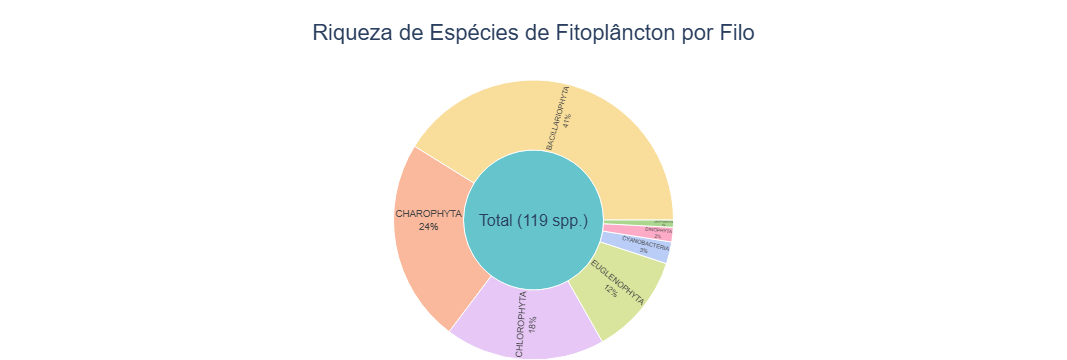

In [3]:
# --- Bloco 3: Gráfico Sunburst de Riqueza por Filo ---

import plotly.express as px

print("Iniciando a criação do Gráfico Sunburst de Riqueza por Filo...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS PARA O GRÁFICO
    print("   -> Preparando os dados para o gráfico...")
    # Removemos registros onde o filo não está definido para garantir a qualidade do gráfico
    sunburst_data = df_fito_limpo.dropna(subset=['filo', 'nome_cientifico']).copy()
    
    # Agrupamos por Filo e contamos o número de espécies ÚNICAS (riqueza)
    sunburst_data = sunburst_data.groupby('filo')['nome_cientifico'].nunique().reset_index()
    sunburst_data.rename(columns={'nome_cientifico': 'Riqueza'}, inplace=True)
    
    # Criamos a raiz do gráfico (o círculo central)
    total_riqueza = sunburst_data['Riqueza'].sum()
    sunburst_data['Centro'] = f"Total ({total_riqueza} spp.)"
    print("   -> Dados agregados com sucesso.")

    # 2. CRIAÇÃO DO GRÁFICO COM PLOTLY
    print("   -> Gerando o gráfico...")
    fig = px.sunburst(
        sunburst_data,
        path=['Centro', 'filo'],  # Define a hierarquia: do centro para os filos
        values='Riqueza',         # O tamanho das fatias é determinado pela riqueza
        color='filo',
        color_discrete_sequence=px.colors.qualitative.Pastel, # Paleta de cores suaves
    )

    # 3. CUSTOMIZAÇÃO (Seguindo o Guia de Estilo)
    # Título centralizado e fonte Arial
    fig.update_layout(
        title_text='Riqueza de Espécies de Fitoplâncton por Filo',
        title_x=0.5,
        font=dict(family="Arial", size=16),
        margin=dict(t=80, l=0, r=0, b=0)
    )
    
    # Informações exibidas nas fatias e no tooltip de hover
    fig.update_traces(
        textinfo='label+percent root', # Mostra o nome do filo e a % do total
        insidetextorientation='radial',
        hovertemplate='<b>%{label}</b><br>Riqueza: %{value} espécies<br>Proporção da Riqueza Total: %{percentRoot:.1%}'
    )

    # 4. SALVAR E EXIBIR
    # Salvar como imagem estática (.png)
    nome_arquivo_png = 'grafico_riqueza_sunburst_fitoplancton.png'
    caminho_completo_png = os.path.join(caminho_saida_grupo, nome_arquivo_png)
    try:
        # 'scale=2' aumenta a resolução da imagem
        fig.write_image(caminho_completo_png, width=1000, height=1000, scale=2)
        print(f"\n_Gráfico Sunburst salvo como IMAGEM em: '{caminho_completo_png}'_")
    except ValueError:
        print("\nAVISO: O pacote 'kaleido' parece não estar instalado. A imagem .png não foi salva.")
        print("Para instalar, ative o ambiente 'env_fito' e execute: conda install -c conda-forge python-kaleido")
    
    # Salvar como arquivo interativo (.html)
    nome_arquivo_html = 'grafico_riqueza_sunburst_fitoplancton_interativo.html'
    caminho_completo_html = os.path.join(caminho_saida_grupo, nome_arquivo_html)
    fig.write_html(caminho_completo_html)
    print(f"_Gráfico Sunburst salvo como HTML INTERATIVO em: '{caminho_completo_html}'_")

    fig.show()

Iniciando a criação do Gráfico de Riqueza (versão final)...
   -> Dados de riqueza calculados com sucesso.
   -> Gerando o gráfico...

_Gráfico salvo com sucesso em: '..\03_relatorios\fitoplancton\grafico_riqueza_ponto_fitoplancton.png'_


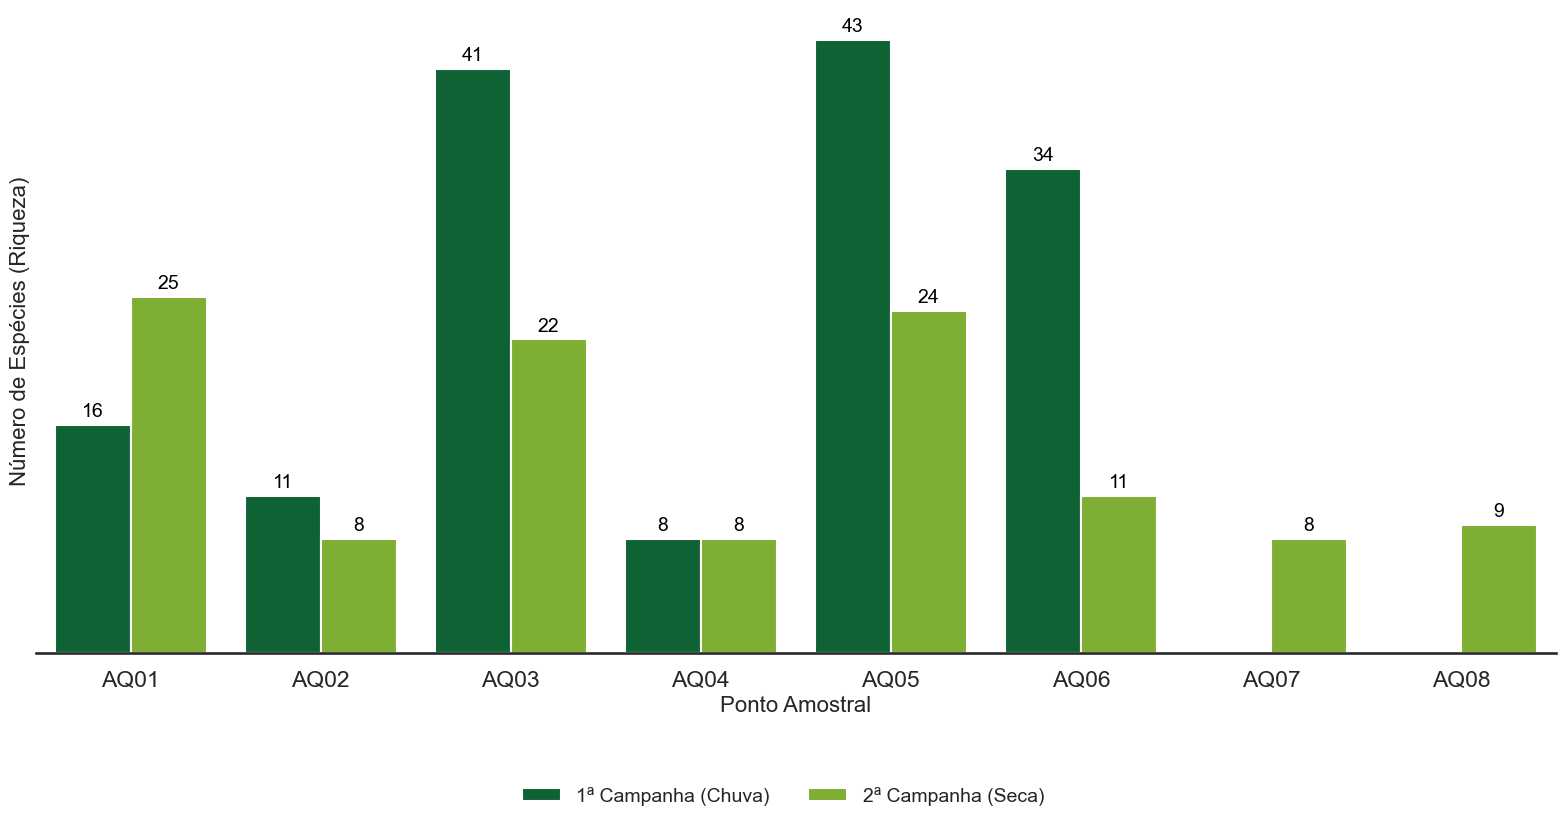

In [4]:
# --- Bloco 4 (Revisado Final): Gráfico de Riqueza de Espécies por Ponto Amostral ---

print("Iniciando a criação do Gráfico de Riqueza (versão final)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    df_riqueza_ponto = df_fito_limpo.groupby(['ponto_amostral', 'campanha'])['nome_cientifico'].nunique().reset_index()
    df_riqueza_ponto.rename(columns={'nome_cientifico': 'riqueza_de_especies'}, inplace=True)
    print("   -> Dados de riqueza calculados com sucesso.")

    # 2. CRIAÇÃO DO GRÁFICO (inalterado)
    print("   -> Gerando o gráfico...")
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(16, 8))
    cores_personalizadas = ["#007032", "#82C21F"]

    sns.barplot(
        data=df_riqueza_ponto,
        x='ponto_amostral',
        y='riqueza_de_especies',
        hue='campanha',
        palette=cores_personalizadas,
        ax=ax
    )

    # 3. CUSTOMIZAÇÃO (com as suas sugestões)
    for container in ax.containers:
        ax.bar_label(container, fontsize=14, fmt='%d', color='black', padding=3)

    ax.set_xlabel('Ponto Amostral', fontsize=16, fontname='Arial')
    ax.set_ylabel('Número de Espécies (Riqueza)', fontsize=16, fontname='Arial')
    
    # <<-- SUGESTÃO 1: TÍTULO REMOVIDO -->>
    # A linha ax.set_title() foi omitida.
        
    ax.set_yticks([])
    
    # <<-- SUGESTÃO 2: LÓGICA DE FORMATAÇÃO DA LEGENDA -->>
    # Remove a legenda original gerada pelo Seaborn
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    # Pega os 'handles' (as cores) e os 'labels' (os textos originais) da legenda
    handles, original_labels = ax.get_legend_handles_labels()
    
    # Cria uma nova lista de labels, transformando os textos originais
    novos_labels = []
    for label in original_labels:
        # Substitui "1 " por "1ª " e "2 " por "2ª " no início do texto
        novo_label = label.replace('1 ', '1ª ', 1).replace('2 ', '2ª ', 1)
        novos_labels.append(novo_label)
    
    # Cria a nova legenda com os textos formatados
    fig.legend(
        handles,
        novos_labels, # <<-- USA OS NOVOS LABELS AQUI
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(novos_labels),
        frameon=False,
        fontsize=14
    )

    # Ajustes finais de layout
    sns.despine(left=True)
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # 4. SALVAR O GRÁFICO (inalterado)
    nome_arquivo = 'grafico_riqueza_ponto_fitoplancton.png'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    print(f"\n_Gráfico salvo com sucesso em: '{caminho_completo}'_")
    
    plt.show()

Iniciando a criação do Gráfico de Riqueza por Filo (padrão 'clean')...
   -> Dados de riqueza por Filo calculados e ordenados com sucesso.
   -> Gerando o gráfico...

_Gráfico salvo com sucesso em: '..\03_relatorios\fitoplancton\grafico_riqueza_por_filo_fitoplancton.png'_


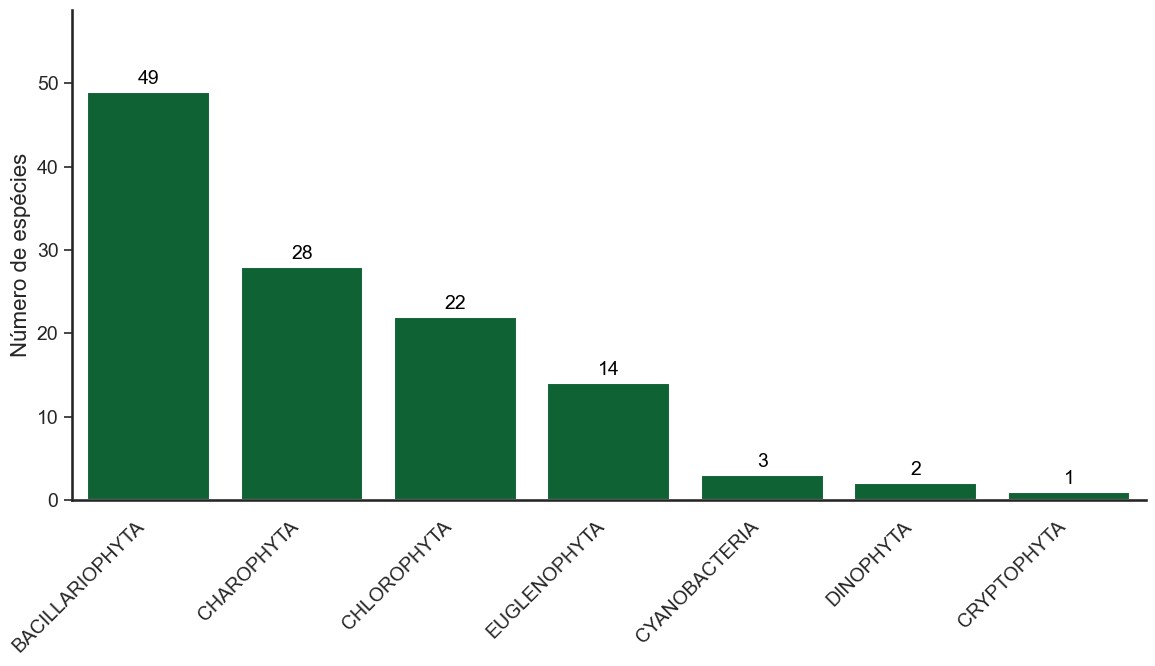

In [5]:
# --- Bloco 5 (Revisado Final): Gráfico de Riqueza por Filo (Marcas de Escala para Fora) ---

print("Iniciando a criação do Gráfico de Riqueza por Filo (padrão 'clean')...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    df_riqueza_filo = df_fito_limpo.groupby('filo')['nome_cientifico'].nunique().reset_index()
    df_riqueza_filo.rename(columns={'nome_cientifico': 'riqueza'}, inplace=True)
    df_riqueza_filo = df_riqueza_filo.sort_values(by='riqueza', ascending=False)
    print("   -> Dados de riqueza por Filo calculados e ordenados com sucesso.")

    # 2. CRIAÇÃO DO GRÁFICO (inalterado)
    print("   -> Gerando o gráfico...")
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(12, 7))

    sns.barplot(
        data=df_riqueza_filo,
        x='filo',
        y='riqueza',
        color="#007032",
        ax=ax
    )

    # 3. CUSTOMIZAÇÃO (com a alteração na direção das marcas)
    for container in ax.containers:
        ax.bar_label(container, fontsize=14, fmt='%d', color='black', padding=3)

    ax.set_xlabel(None)
    ax.set_ylabel('Número de espécies', fontsize=16, fontname='Arial')
    
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    
    ax.grid(False)
    sns.despine()
    
    # <<-- MUDANÇA PRINCIPAL AQUI: 'direction' alterado para 'out' -->>
    ax.tick_params(axis='y', direction='out', left=True, length=6, width=1.2) # 'length' e 'width' para melhor visibilidade
    
    y_max = df_riqueza_filo['riqueza'].max()
    ax.set_ylim(0, y_max * 1.2)
    
    plt.tight_layout()

    # 4. SALVAR O GRÁFICO (inalterado)
    nome_arquivo = 'grafico_riqueza_por_filo_fitoplancton.png'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    print(f"\n_Gráfico salvo com sucesso em: '{caminho_completo}'_")
    
    plt.show()

Iniciando a criação do Gráfico de Composição (com separador inferior)...
   -> Dados pivotados para o formato do gráfico.
   -> Gráfico base gerado com a paleta de cores personalizada.

_Gráfico salvo com sucesso em: '..\03_relatorios\fitoplancton\grafico_composicao_riqueza_fitoplancton.png'_


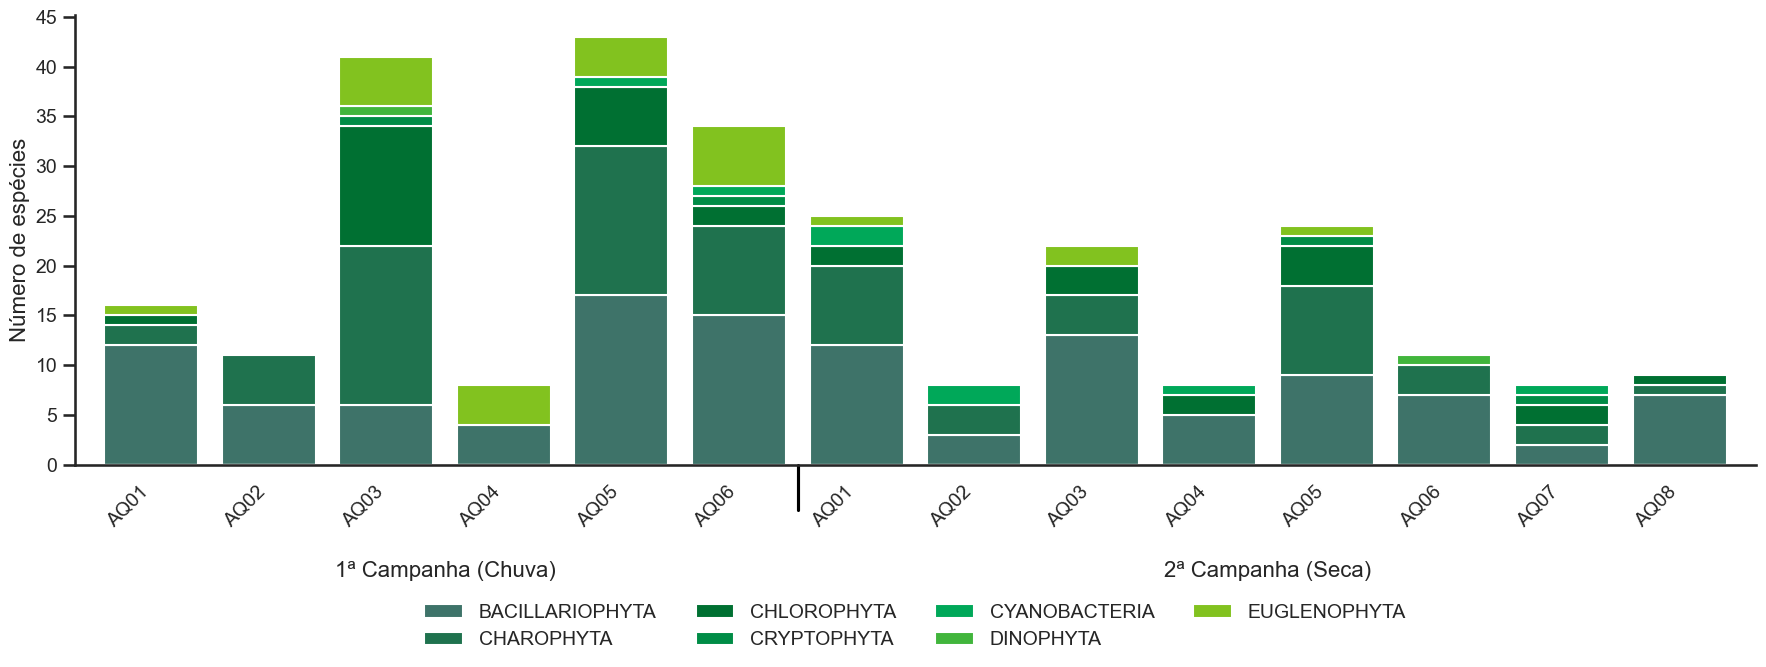

In [6]:
# --- Bloco 6 (Corrigido Final): Gráfico de Composição com Separador Inferior ---
import numpy as np
import matplotlib.colors as mcolors

print("Iniciando a criação do Gráfico de Composição (com separador inferior)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    df_riqueza_empilhada = df_fito_limpo.groupby(['campanha', 'ponto_amostral', 'filo'])['nome_cientifico'].nunique().reset_index()
    df_riqueza_empilhada.rename(columns={'nome_cientifico': 'riqueza'}, inplace=True)
    pivot_df = df_riqueza_empilhada.pivot_table(
        index=['campanha', 'ponto_amostral'], columns='filo', values='riqueza', fill_value=0
    )
    print("   -> Dados pivotados para o formato do gráfico.")

    # 2. CRIAÇÃO DO GRÁFICO E PALETA PERSONALIZADA (inalterado)
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(18, 9))

    cores_principais = ['#3E7369', '#007032', '#00A859', '#82C21F']
    n_filos = len(pivot_df.columns)
    cores = cores_principais[:n_filos] if n_filos <= len(cores_principais) else [mcolors.LinearSegmentedColormap.from_list("paleta", cores_principais, N=n_filos)(i) for i in range(n_filos)]

    pivot_df.plot(kind='bar', stacked=True, ax=ax, color=cores, width=0.8)
    print("   -> Gráfico base gerado com a paleta de cores personalizada.")

    # 3. CUSTOMIZAÇÃO (com o nome da variável corrigido)
    ax.set_ylabel('Número de espécies', fontsize=16, fontname='Arial')
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)); ax.tick_params(axis='y', labelsize=14, direction='out', left=True)
    ax.set_xlabel(None); ax.set_xticklabels([p[1] for p in pivot_df.index], rotation=45, ha='right', fontsize=14)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4, frameon=False, fontsize=14, title=None)
    ax.grid(False); sns.despine()
    
    # Lógica da Linha Separadora Inferior
    espessura_eixo = ax.spines['bottom'].get_linewidth()
    
    campanha_boundaries = [0]; campanhas = pivot_df.index.get_level_values('campanha')
    for i in range(1, len(campanhas)):
        if campanhas[i] != campanhas[i-1]:
            posicao_linha = i - 0.5
            ax.plot([posicao_linha, posicao_linha], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax.get_xaxis_transform(), clip_on=False)
            campanha_boundaries.append(i)
    
    campanha_boundaries.append(len(campanhas))
    
    # <<-- CORREÇÃO AQUI: 'boundaries' alterado para 'campanha_boundaries' -->>
    for i in range(len(campanha_boundaries) - 1):
        start, end = campanha_boundaries[i], campanha_boundaries[i+1]; mid = start + (end-start)/2 - 0.5
        label = campanhas[start].replace('1 ','1ª ',1).replace('2 ','2ª ',1)
        ax.text(mid, -0.25, label, ha='center', transform=ax.get_xaxis_transform(), fontsize=16)

    plt.tight_layout(rect=[0, 0.1, 1, 1])

    # 4. SALVAR O GRÁFICO (inalterado)
    nome_arquivo = 'grafico_composicao_riqueza_fitoplancton.png'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    print(f"\n_Gráfico salvo com sucesso em: '{caminho_completo}'_")
    
    plt.show()

In [7]:
# --- Bloco 7 (Refinado Final): Tabela de Ocorrência Completa (com 'X' para Qualitativos) ---

print("Iniciando a criação da Tabela de Ocorrência (versão final sem avisos)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. OBTER LISTAS MESTRAS E ORDENADAS (inalterado)
    campanhas_ordenadas = sorted(df_fito_limpo['campanha'].unique())
    pontos_ordenados = sorted(df_fito_limpo['ponto_amostral'].unique())
    especies_ordenadas = sorted(df_fito_limpo['nome_cientifico'].dropna().unique())
    print(f"   -> Análise baseada em {len(campanhas_ordenadas)} campanhas, {len(pontos_ordenados)} pontos e {len(especies_ordenadas)} espécies.")

    lista_tabelas_por_campanha = []

    # 2. PROCESSAR CADA CAMPANHA INDIVIDUALMENTE
    for campanha in campanhas_ordenadas:
        print(f"   -> Processando dados para: {campanha}...")
        
        df_campanha_atual = df_fito_limpo[df_fito_limpo['campanha'] == campanha]
        df_quant = df_campanha_atual[df_campanha_atual['tipo_amostragem'] == 'Quantitativo']
        matriz_quant = df_quant.pivot_table(index='nome_cientifico', columns='ponto_amostral', values='densidade', aggfunc='sum')
        df_qual = df_campanha_atual[df_campanha_atual['tipo_amostragem'] == 'Qualitativo']
        matriz_qual = df_qual.pivot_table(index='nome_cientifico', columns='ponto_amostral', values='densidade', aggfunc=lambda x: 'X')
        tabela_pivot_completa = matriz_quant.reindex(index=especies_ordenadas, columns=pontos_ordenados)
        tabela_pivot_completa.fillna(matriz_qual, inplace=True)
        
        # 3. CÁLCULO DE RESUMOS (inalterado)
        total_pontos = len(pontos_ordenados)
        tabela_pivot_completa['OC'] = tabela_pivot_completa[pontos_ordenados].notna().sum(axis=1)
        if total_pontos > 0:
            tabela_pivot_completa['%OC'] = (tabela_pivot_completa['OC'] / total_pontos) * 100
        else:
            tabela_pivot_completa['%OC'] = 0
        
        densidade_total = tabela_pivot_completa[pontos_ordenados].apply(pd.to_numeric, errors='coerce').sum(axis=0)
        densidade_total.name = 'Densidade Total'
        riqueza = tabela_pivot_completa[pontos_ordenados].notna().sum(axis=0)
        riqueza.name = 'Riqueza'
        
        # <<-- CORREÇÃO AQUI: Garante que todos os DataFrames a serem concatenados tenham o mesmo tipo -->>
        # Converte a matriz principal e as linhas de resumo para 'object' ANTES de concatenar.
        tabela_campanha_final = pd.concat([
            tabela_pivot_completa.astype(object), 
            densidade_total.to_frame().T.astype(object), 
            riqueza.to_frame().T.astype(object)
        ])
        
        lista_tabelas_por_campanha.append(tabela_campanha_final)

    # 4. JUNTAR E FORMATAR A TABELA FINAL (inalterado)
    if lista_tabelas_por_campanha:
        tabela_final = pd.concat(lista_tabelas_por_campanha, axis=1, keys=campanhas_ordenadas)
        tabela_final.index.name = 'Espécie'
        tabela_final.fillna('', inplace=True)

        for campanha in campanhas_ordenadas:
            col_oc_percent = (campanha, '%OC')
            if col_oc_percent in tabela_final.columns:
                 tabela_final[col_oc_percent] = tabela_final[col_oc_percent].apply(
                    lambda x: f"{float(x):.0f}%" if x != '' else ''
                )
        print("   -> Tabela final consolidada e formatada.")

        # 5. SALVAR EM EXCEL (inalterado)
        nome_arquivo = 'tabela_ocorrencia_fitoplancton_com_X.xlsx'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        tabela_final.to_excel(caminho_completo, sheet_name='Ocorrencia_Fitoplancton')
        
        print(f"\n_Tabela de Ocorrência salva com sucesso em: '{caminho_completo}'_")
        
        print("\n**Visualização da Tabela Final (com 'X' para qualitativos):**")
        display(tabela_final)
    else:
        print("\nNenhuma campanha encontrada para processar.")

Iniciando a criação da Tabela de Ocorrência (versão final sem avisos)...
   -> Análise baseada em 2 campanhas, 8 pontos e 119 espécies.
   -> Processando dados para: 1 Campanha (Chuva)...
   -> Processando dados para: 2 Campanha (Seca)...
   -> Tabela final consolidada e formatada.

_Tabela de Ocorrência salva com sucesso em: '..\03_relatorios\fitoplancton\tabela_ocorrencia_fitoplancton_com_X.xlsx'_

**Visualização da Tabela Final (com 'X' para qualitativos):**


1 Campanha (Chuva)                       \
ponto_amostral                            AQ01 AQ02       AQ03 AQ04   
Espécie                                                               
Achnanthidium catenatum                                               
Achnanthidium minutissimum                                            
Actinella sp.                                                         
Actinotaenium cucurbita                                               
Actinotaenium globosum                                       X        
...                                        ...  ...        ...  ...   
Trachelomonas volvocina                                      X    X   
Trachelomonas volvocinopsis                                       X   
Ulnaria ulna                                 X    X          X        
Densidade Total                       8.941176  0.0  377.69697  0.0   
Riqueza                                     16   11         41    8   

                                                                     \
ponto_amostral                    AQ05       AQ06 AQ07 AQ08 OC  %OC   
Espécie                                                               
Achnanthidium catenatum                                      0   0%   
Achnanthidium minutissimum           X                       1  12%   
Actinella sp.                                                0   0%   
Actinotaenium cucurbita                                      0   0%   
Actinotaenium globosum        9.212121                       2  25%   
...                                ...        ...  ...  ... ..  ...   
Trachelomonas volvocina                                      2  25%   
Trachelomonas volvocinopsis                                  1  12%   
Ulnaria ulna                         X          X            5  62%   
Densidade Total              64.484848  43.428571  0.0  0.0           
Riqueza                             43         34    0    0           

                            2 Campanha (Seca)                                  \
ponto_amostral                           AQ01     AQ02        AQ03       AQ04   
Espécie                                                                         
Achnanthidium catenatum                     X             4.848485              
Achnanthidium minutissimum                                                      
Actinella sp.                                                    X              
Actinotaenium cucurbita                     X        X     9.69697              
Actinotaenium globosum                      X                                   
...                                       ...      ...         ...        ...   
Trachelomonas volvocina                                   4.848485              
Trachelomonas volvocinopsis                                                     
Ulnaria ulna                                X                               X   
Densidade Total                     19.393939  9.69697  198.787879  19.393939   
Riqueza                                    25        8          22          8   

                                                                             \
ponto_amostral                     AQ05       AQ06       AQ07       AQ08 OC   
Espécie                                                                       
Achnanthidium catenatum         9.69697   4.848485                        4   
Achnanthidium minutissimum                                                0   
Actinella sp.                                    X                        2   
Actinotaenium cucurbita               X                     X             5   
Actinotaenium globosum                                                    1   
...                                 ...        ...        ...        ... ..   
Trachelomonas volvocina                                                   1   
Trachelomonas volvocinopsis                                               0   
Ulnaria ulna                  72.7

Iniciando a criação dos gráficos de densidade (estilo final)...
   -> Dados para densidade absoluta e relativa preparados.

[1/2] Gerando Gráfico de Densidade Absoluta...
   -> Gráfico salvo com sucesso em: '..\03_relatorios\fitoplancton\grafico_densidade_absoluta_fitoplancton.png'


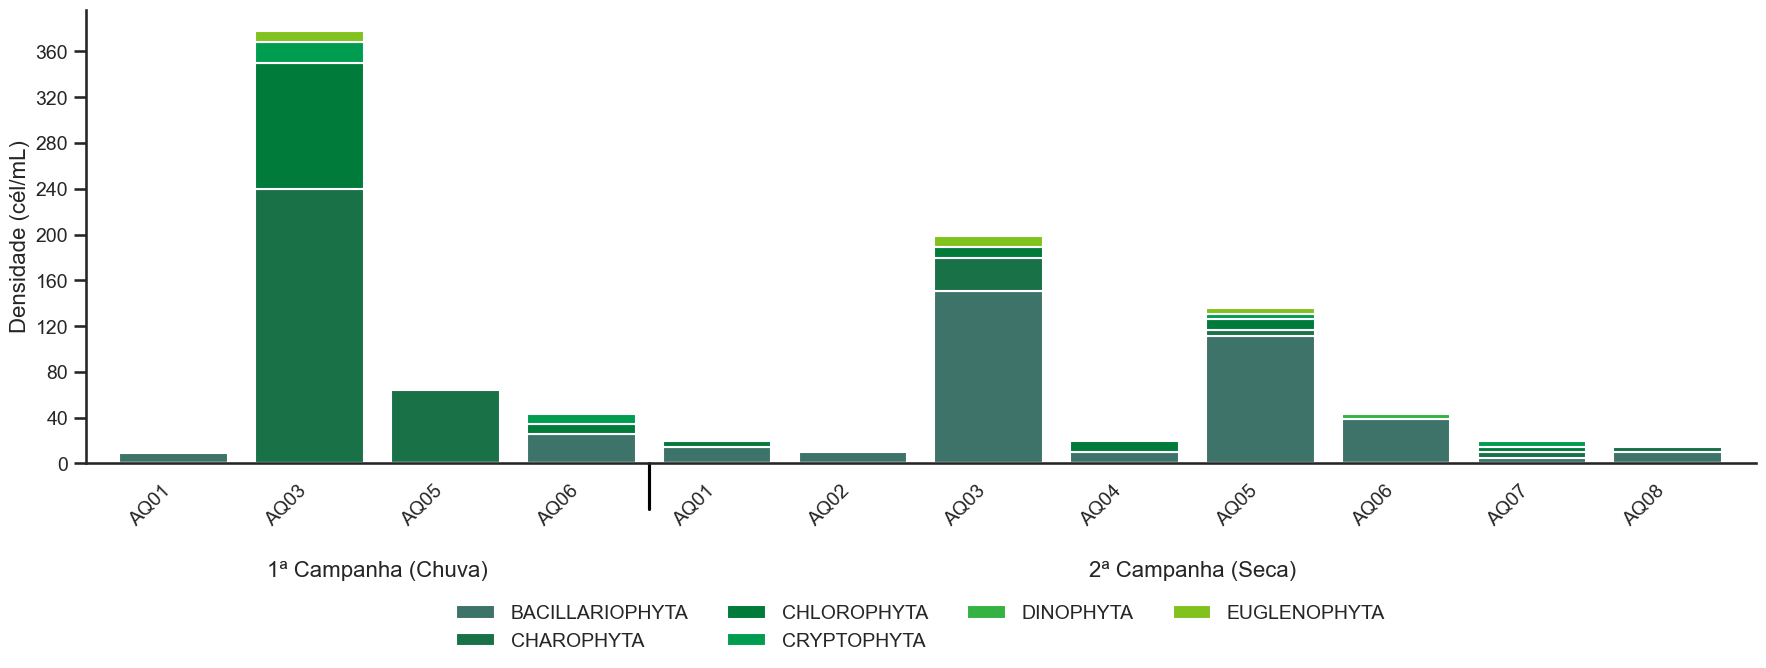


[2/2] Gerando Gráfico de Densidade Relativa...
   -> Gráfico salvo com sucesso em: '..\03_relatorios\fitoplancton\grafico_densidade_relativa_fitoplancton.png'


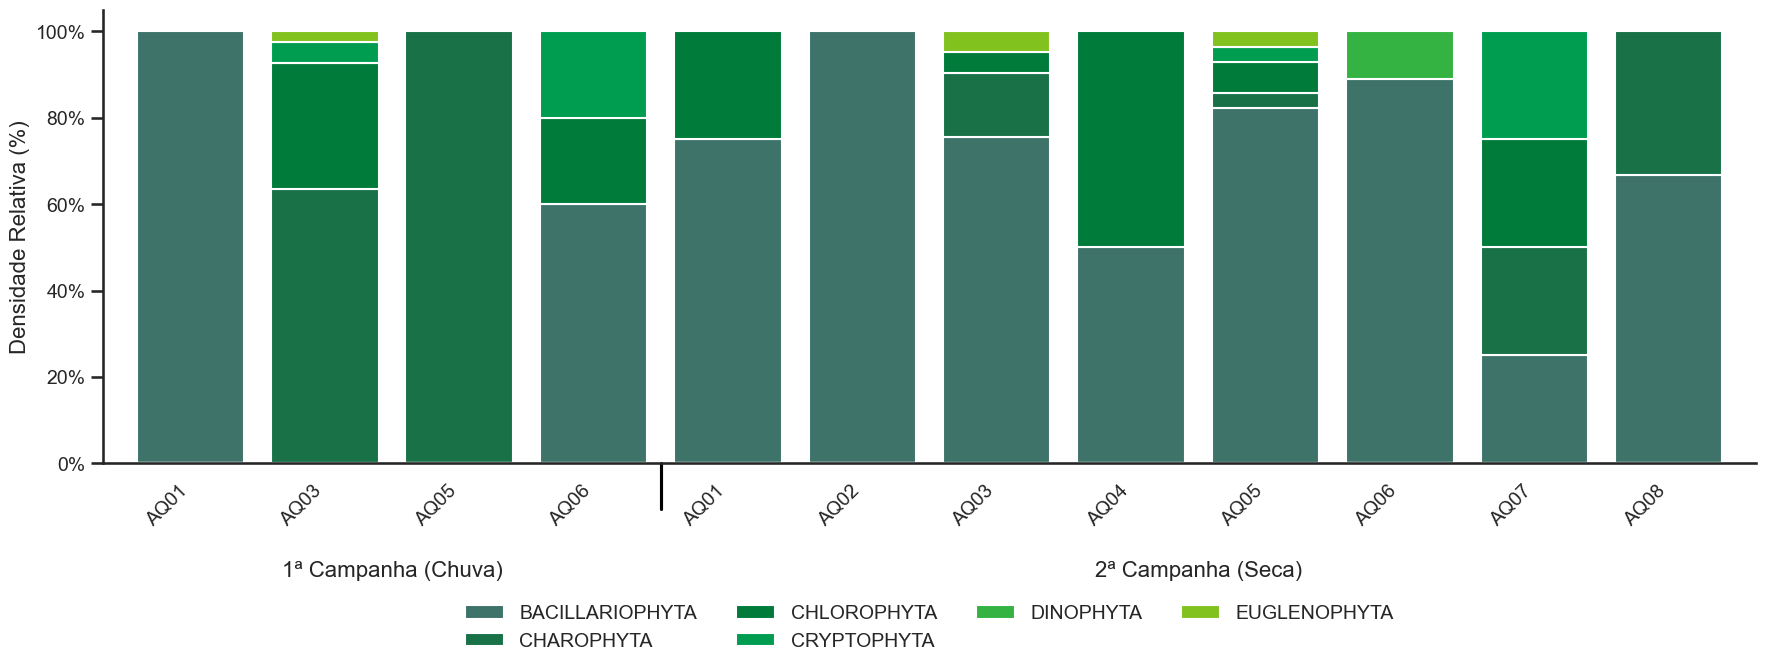

In [8]:
# --- Bloco 8 (Revisado e Padronizado): Gráficos de Densidade com Estilo Final ---
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

print("Iniciando a criação dos gráficos de densidade (estilo final)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    df_quant = df_fito_limpo[df_fito_limpo['tipo_amostragem'] == 'Quantitativo'].copy()
    if df_quant.empty or df_quant['densidade'].sum() == 0:
        print("AVISO: Nenhum dado quantitativo com densidade > 0 foi encontrado. Gráficos não podem ser gerados.")
    else:
        df_densidade_filo = df_quant.groupby(['campanha', 'ponto_amostral', 'filo'])['densidade'].sum().reset_index()
        pivot_abs = df_densidade_filo.pivot_table(index=['campanha', 'ponto_amostral'], columns='filo', values='densidade', fill_value=0)
        pivot_rel = pivot_abs.div(pivot_abs.sum(axis=1), axis=0) * 100
        pivot_rel.fillna(0, inplace=True)
        print("   -> Dados para densidade absoluta e relativa preparados.")

        # Paleta de cores (inalterado)
        cores_principais = ['#3E7369', '#007032', '#00A859', '#82C21F']
        n_filos = len(pivot_abs.columns)
        cores = cores_principais[:n_filos] if n_filos <= len(cores_principais) else [mcolors.LinearSegmentedColormap.from_list("paleta", cores_principais, N=n_filos)(i) for i in range(n_filos)]

        # --- GRÁFICO 1: DENSIDADE ABSOLUTA ---
        print("\n[1/2] Gerando Gráfico de Densidade Absoluta...")
        fig1, ax1 = plt.subplots(figsize=(18, 9))
        pivot_abs.plot(kind='bar', stacked=True, ax=ax1, color=cores, width=0.8)

        # Customização
        ax1.set_ylabel('Densidade (cél/mL)', fontsize=16, fontname='Arial')
        ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        # <<-- AJUSTE 1: Marcas de escala para fora -->>
        ax1.tick_params(axis='y', labelsize=14, direction='out', left=True)
        ax1.set_xlabel(None); ax1.set_xticklabels([p[1] for p in pivot_abs.index], rotation=45, ha='right', fontsize=14)
        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4, frameon=False, fontsize=14, title=None)
        ax1.grid(False); sns.despine(ax=ax1)
        
        # Lógica da Linha Separadora Ajustada
        espessura_eixo = ax1.spines['bottom'].get_linewidth()
        boundaries = [0]; campanhas = pivot_abs.index.get_level_values('campanha')
        for i in range(1, len(campanhas)):
            if campanhas[i] != campanhas[i-1]:
                # <<-- AJUSTE 2: Cor do separador para 'black' -->>
                ax1.plot([i - 0.5, i - 0.5], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax1.get_xaxis_transform(), clip_on=False)
                boundaries.append(i)
        boundaries.append(len(campanhas))
        for i in range(len(boundaries) - 1):
            start, end = boundaries[i], boundaries[i+1]; mid = start + (end-start)/2 - 0.5
            label = campanhas[start].replace('1 ','1ª ',1).replace('2 ','2ª ',1)
            ax1.text(mid, -0.25, label, ha='center', transform=ax1.get_xaxis_transform(), fontsize=16)

        plt.tight_layout(rect=[0, 0.1, 1, 1])
        nome_arquivo1 = 'grafico_densidade_absoluta_fitoplancton.png'
        caminho_completo1 = os.path.join(caminho_saida_grupo, nome_arquivo1)
        plt.savefig(caminho_completo1, dpi=300, bbox_inches='tight')
        print(f"   -> Gráfico salvo com sucesso em: '{caminho_completo1}'")
        plt.show()

        # --- GRÁFICO 2: DENSIDADE RELATIVA (PERCENTUAL) ---
        print("\n[2/2] Gerando Gráfico de Densidade Relativa...")
        fig2, ax2 = plt.subplots(figsize=(18, 9))
        pivot_rel.plot(kind='bar', stacked=True, ax=ax2, color=cores, width=0.8)
        
        # Customização
        ax2.set_ylabel('Densidade Relativa (%)', fontsize=16, fontname='Arial')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
        # <<-- AJUSTE 1: Marcas de escala para fora -->>
        ax2.tick_params(axis='y', labelsize=14, direction='out', left=True)
        ax2.set_xlabel(None); ax2.set_xticklabels([p[1] for p in pivot_rel.index], rotation=45, ha='right', fontsize=14)
        ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4, frameon=False, fontsize=14, title=None)
        ax2.grid(False); sns.despine(ax=ax2)

        # Lógica da Linha Separadora Ajustada
        espessura_eixo = ax2.spines['bottom'].get_linewidth()
        boundaries = [0]; campanhas = pivot_rel.index.get_level_values('campanha')
        for i in range(1, len(campanhas)):
            if campanhas[i] != campanhas[i-1]:
                # <<-- AJUSTE 2: Cor do separador para 'black' -->>
                ax2.plot([i - 0.5, i - 0.5], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax2.get_xaxis_transform(), clip_on=False)
                boundaries.append(i)
        boundaries.append(len(campanhas))
        for i in range(len(boundaries) - 1):
            start, end = boundaries[i], boundaries[i+1]; mid = start + (end-start)/2 - 0.5
            label = campanhas[start].replace('1 ','1ª ',1).replace('2 ','2ª ',1)
            ax2.text(mid, -0.25, label, ha='center', transform=ax2.get_xaxis_transform(), fontsize=16)

        plt.tight_layout(rect=[0, 0.1, 1, 1])
        nome_arquivo2 = 'grafico_densidade_relativa_fitoplancton.png'
        caminho_completo2 = os.path.join(caminho_saida_grupo, nome_arquivo2)
        plt.savefig(caminho_completo2, dpi=300, bbox_inches='tight')
        print(f"   -> Gráfico salvo com sucesso em: '{caminho_completo2}'")
        plt.show()

Iniciando a criação do Gráfico de Diversidade (separador na cor do eixo)...
   -> Filtrando dados para incluir apenas amostras quantitativas...
   -> Matriz de comunidade criada com sucesso.
   -> Índices calculados com sucesso.
   -> Gerando o gráfico...

_Gráfico salvo com sucesso em: '..\03_relatorios\fitoplancton\grafico_diversidade_equitabilidade_fitoplancton.png'_


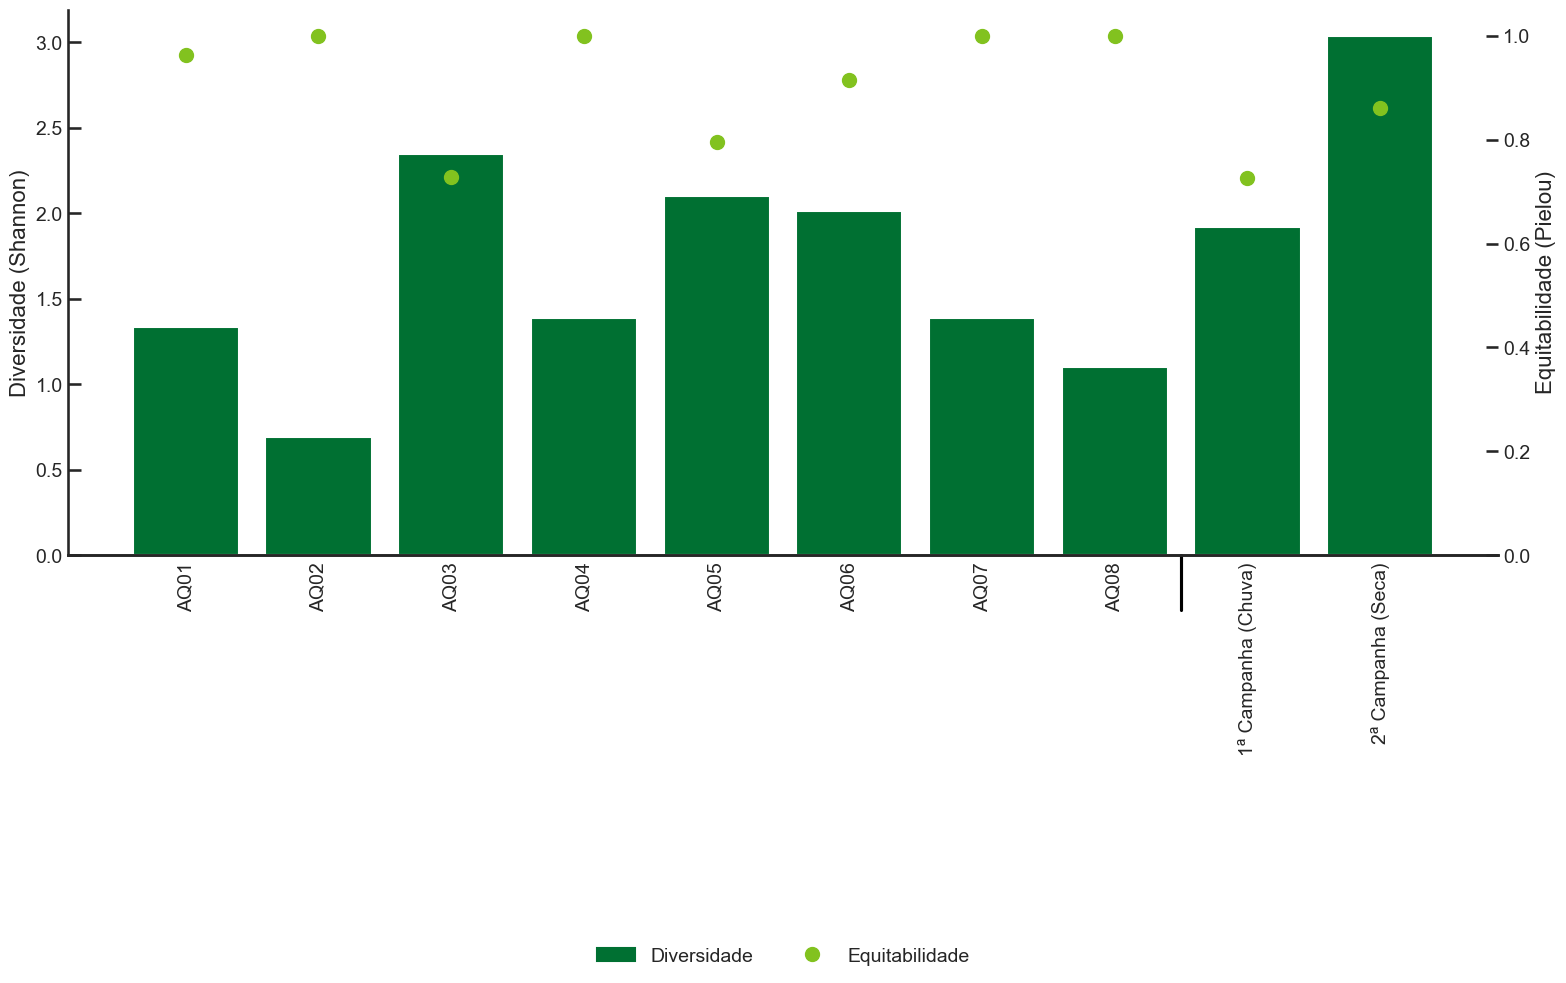

In [9]:
# --- Bloco 9 (Revisado Final): Gráfico de Diversidade com Separador Inferior na Cor do Eixo ---
import numpy as np
import skbio.diversity
from matplotlib.patches import Patch

print("Iniciando a criação do Gráfico de Diversidade (separador na cor do eixo)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    print("   -> Filtrando dados para incluir apenas amostras quantitativas...")
    df_quant = df_fito_limpo[df_fito_limpo['tipo_amostragem'] == 'Quantitativo'].copy()
    
    if df_quant.empty or df_quant['densidade'].sum() == 0:
        print("AVISO: Nenhum dado quantitativo com densidade > 0 foi encontrado. Índices não podem ser calculados.")
    else:
        matriz_pontos = df_quant.pivot_table(index='ponto_amostral', columns='nome_cientifico', values='densidade', aggfunc='sum', fill_value=0)
        matriz_pontos = matriz_pontos.loc[matriz_pontos.sum(axis=1) > 0]
        matriz_campanhas = df_quant.pivot_table(index='campanha', columns='nome_cientifico', values='densidade', aggfunc='sum', fill_value=0)
        matriz_total = pd.concat([matriz_pontos, matriz_campanhas])
        print("   -> Matriz de comunidade criada com sucesso.")

        # 2. CÁLCULO DOS ÍNDICES (inalterado)
        shannon_h = matriz_total.apply(lambda row: skbio.diversity.alpha.shannon(row, base=np.e), axis=1)
        pielou_j = matriz_total.apply(lambda row: skbio.diversity.alpha.pielou_e(row), axis=1)
        df_resultados_div = pd.DataFrame({'Diversidade': shannon_h, 'Equitabilidade': pielou_j})
        print("   -> Índices calculados com sucesso.")

        # 3. VISUALIZAÇÃO DO GRÁFICO
        print("   -> Gerando o gráfico...")
        sns.set_theme(style="white", context="talk")
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        cor_diversidade = "#007032"; cor_equitabilidade = "#82C21F"

        # Eixo Esquerdo (ax1): Barras de Diversidade
        ax1.bar(df_resultados_div.index, df_resultados_div['Diversidade'], color=cor_diversidade)
        ax1.set_ylabel('Diversidade (Shannon)', fontsize=16, fontname='Arial')
        ax1.tick_params(axis='y', labelsize=14, direction='in')
        ax1.set_xlabel(None)
        
        rotulos_x_formatados = [label.replace('1 ', '1ª ', 1).replace('2 ', '2ª ', 1) for label in df_resultados_div.index]
        ax1.set_xticks(range(len(rotulos_x_formatados)))
        ax1.set_xticklabels(rotulos_x_formatados, rotation=90, ha='center', fontsize=14)
        ax1.tick_params(axis='x', direction='in', pad=5)
        
        # Eixo Direito (ax2): Pontos de Equitabilidade
        ax2 = ax1.twinx()
        ax2.plot(df_resultados_div.index, df_resultados_div['Equitabilidade'], marker='o', linestyle='None', color=cor_equitabilidade, markersize=10)
        ax2.set_ylabel('Equitabilidade (Pielou)', fontsize=16, fontname='Arial')
        ax2.set_ylim(0, 1.05); ax2.tick_params(axis='y', labelsize=14, direction='in')

        # <<-- MUDANÇA PRINCIPAL AQUI: Cor da Linha Separadora -->>
        posicao_linha = len(matriz_pontos) - 0.5
        espessura_eixo = ax1.spines['bottom'].get_linewidth()
        # A cor agora é 'black' para combinar com os eixos.
        ax1.plot([posicao_linha, posicao_linha], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax1.get_xaxis_transform(), clip_on=False)
        
        # Estilo final dos eixos
        ax1.grid(False); ax2.grid(False)
        sns.despine(ax=ax1); sns.despine(ax=ax2, left=True)

        # Legenda Simplificada
        patch_handle = Patch(color=cor_diversidade, label='Diversidade')
        line_handle = ax2.get_lines()[0]
        line_handle.set_label('Equitabilidade')
        fig.legend(handles=[patch_handle, line_handle], loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False, fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 1, 1])

        # 4. SALVAR O GRÁFICO
        nome_arquivo = 'grafico_diversidade_equitabilidade_fitoplancton.png'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
        
        print(f"\n_Gráfico salvo com sucesso em: '{caminho_completo}'_")
        plt.show()

Iniciando a Análise de Similaridade (versão validada)...
   -> Filtrando dados para incluir apenas amostras quantitativas...
   -> Matriz de comunidade criada.
   -> Agrupamento hierárquico realizado.
   -> Gerando o dendrograma com eixo de Similaridade...

_Dendrograma salvo com sucesso em: '..\03_relatorios\fitoplancton\dendrograma_similaridade_fitoplancton.png'_


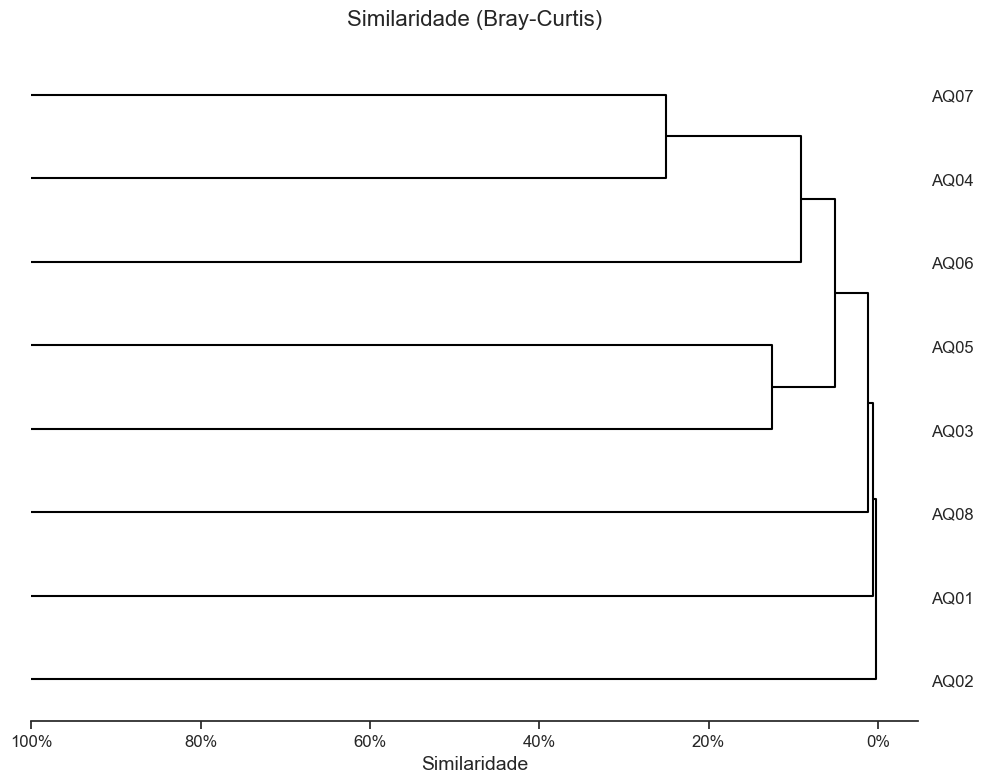

In [10]:
# --- Bloco 10 (Versão Final e Validada): Análise de Similaridade ---
from scipy.cluster.hierarchy import linkage, dendrogram
import skbio.diversity
import matplotlib.ticker as mticker

print("Iniciando a Análise de Similaridade (versão validada)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS
    print("   -> Filtrando dados para incluir apenas amostras quantitativas...")
    df_quant = df_fito_limpo[df_fito_limpo['tipo_amostragem'] == 'Quantitativo'].copy()
    
    if df_quant.empty or df_quant['densidade'].sum() == 0:
        print("AVISO: Nenhum dado quantitativo com densidade > 0 foi encontrado. A análise não pode prosseguir.")
    else:
        matriz_similaridade = df_quant.pivot_table(index='ponto_amostral', columns='nome_cientifico', values='densidade', aggfunc='sum', fill_value=0)
        matriz_similaridade = matriz_similaridade.loc[matriz_similaridade.sum(axis=1) > 0]
        print("   -> Matriz de comunidade criada.")

        # 2. CÁLCULO E AGRUPAMENTO
        distancia_bc = skbio.diversity.beta_diversity('braycurtis', matriz_similaridade.values, ids=matriz_similaridade.index)
        distancia_condensada = distancia_bc.condensed_form()
        linked = linkage(distancia_condensada, method='average')
        print("   -> Agrupamento hierárquico realizado.")

        # 3. GERAR E CUSTOMIZAR O DENDROGRAMA
        print("   -> Gerando o dendrograma com eixo de Similaridade...")
        sns.set_theme(style="white")
        fig, ax = plt.subplots(figsize=(10, 8))

        dendrogram(
            linked,
            orientation='left', # Orientação padrão e funcional
            labels=matriz_similaridade.index.tolist(),
            ax=ax,
            color_threshold=0,
            above_threshold_color='black'
        )
        
        # Lógica validada para converter o eixo para Similaridade em %
        # a) Inverte a direção do eixo X.
        ax.invert_xaxis()
        
        # b) Cria a função para formatar os rótulos do eixo.
        def format_similarity(x, pos):
            return f'{(1 - x) * 100:.0f}%'
        
        # c) Aplica o formatador.
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_similarity))

        # Customização do estilo
        ax.set_title('Similaridade (Bray-Curtis)', loc='center', fontsize=16, fontname='Arial', pad=20)
        ax.set_xlabel('Similaridade', fontsize=14, fontname='Arial')
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=12)
        ax.tick_params(axis='y', which='both', left=False, right=False, labelsize=12)
        sns.despine(left=True)

        plt.tight_layout()

        # 4. SALVAR O GRÁFICO
        nome_arquivo = 'dendrograma_similaridade_fitoplancton.png'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
        
        print(f"\n_Dendrograma salvo com sucesso em: '{caminho_completo}'_")
        plt.show()

Iniciando a análise de Suficiência Amostral (com desvio padrão crescente)...
   -> Gerando o gráfico...

_Gráfico de Suficiência Amostral (std crescente) salvo em: '..\03_relatorios\fitoplancton\grafico_suficiencia_amostral_std_crescente.png'_


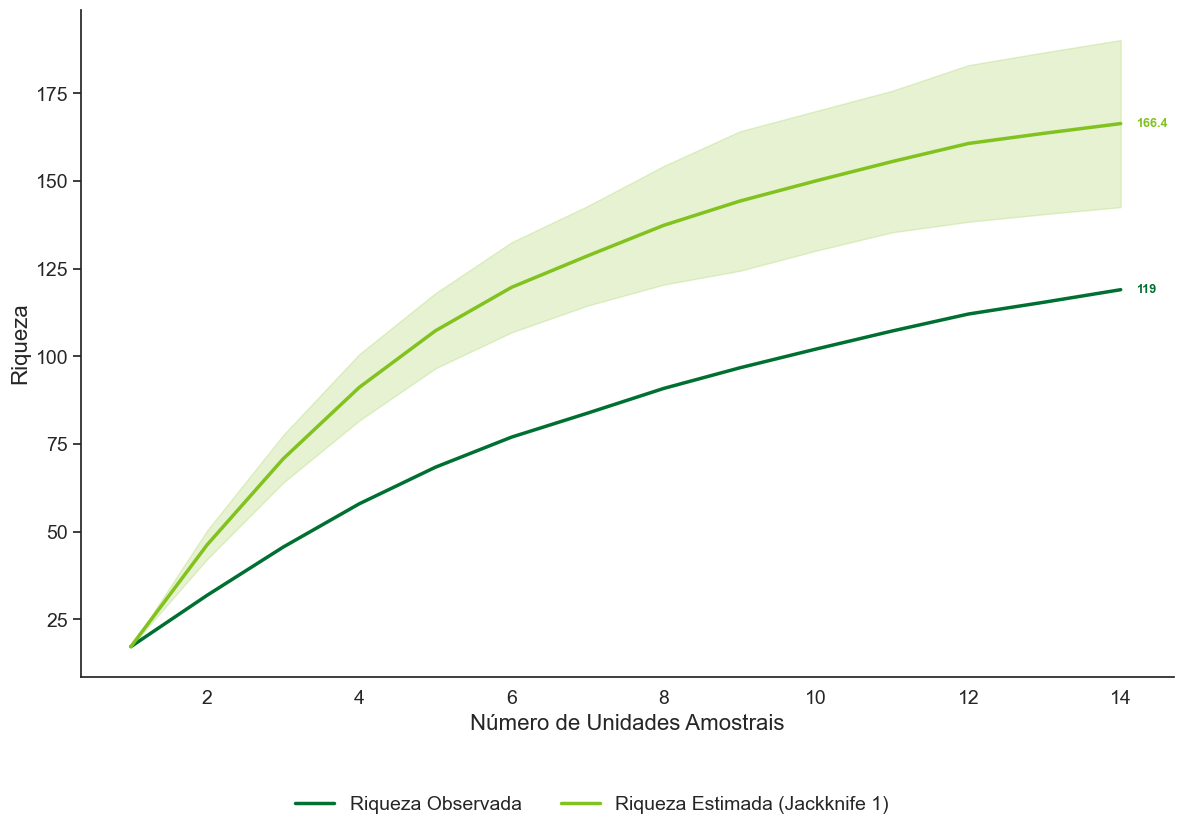

In [33]:
# --- Bloco 11 (Final e Corrigido): Curva de Suficiência com Desvio Padrão Crescente ---
import numpy as np
from matplotlib.lines import Line2D

print("Iniciando a análise de Suficiência Amostral (com desvio padrão crescente)...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    df_suficiencia = df_fito_limpo.copy()
    df_suficiencia['presenca'] = 1
    matriz_suficiencia = df_suficiencia.pivot_table(index=['campanha', 'ponto_amostral'], columns='nome_cientifico', values='presenca', aggfunc='max', fill_value=0)
    n_samples = matriz_suficiencia.shape[0]
    
    if n_samples > 1:
        # 2. FUNÇÃO E SIMULAÇÃO (inalterado)
        def jackknife_1_estimator(matrix):
            S_obs = (matrix.sum(axis=0) > 0).sum(); k = matrix.shape[0]
            if k == 0: return 0
            uniques = (matrix > 0).sum(axis=0); Q1 = (uniques == 1).sum()
            return S_obs + Q1 * ((k - 1) / k)
        
        n_randomizations = 100
        sobs_curves = np.zeros((n_randomizations, n_samples)); sest_curves = np.zeros((n_randomizations, n_samples))
        for rand in range(n_randomizations):
            shuffled_indices = np.random.permutation(n_samples)
            shuffled_matrix = matriz_suficiencia.iloc[shuffled_indices]
            for i in range(1, n_samples + 1):
                subset = shuffled_matrix.iloc[:i, :]; sobs_curves[rand, i-1] = (subset.sum(axis=0) > 0).sum(); sest_curves[rand, i-1] = jackknife_1_estimator(subset)
        
        # 3. AGREGAR RESULTADOS (com a nova lógica de ordenação)
        mean_sobs = sobs_curves.mean(axis=0)
        mean_sest = sest_curves.mean(axis=0)
        std_sest_original = sest_curves.std(axis=0)
        
        # <<-- MUDANÇA PRINCIPAL AQUI: Ordena o desvio padrão de forma crescente -->>
        std_sest_ordenado = np.sort(std_sest_original)

        # 4. GERAR O GRÁFICO
        print("   -> Gerando o gráfico...")
        sns.set_theme(style="white"); fig, ax = plt.subplots(figsize=(12, 8))
        x_axis = np.arange(1, n_samples + 1); cor_rarefacao = "#007032"; cor_estimada = "#82C21F"

        ax.plot(x_axis, mean_sobs, color=cor_rarefacao, linewidth=2.5, label='Riqueza Observada')
        ax.plot(x_axis, mean_sest, color=cor_estimada, linewidth=2.5, label='Riqueza Estimada (Jackknife 1)')
        
        # Usa o desvio padrão ORDENADO para a área de incerteza
        ax.fill_between(x_axis, mean_sest - std_sest_ordenado, mean_sest + std_sest_ordenado, color=cor_estimada, alpha=0.2)
        
        # Rótulos de dados finais
        valor_final_obs = mean_sobs[-1]; valor_final_est = mean_sest[-1]
        ax.text(n_samples + 0.2, valor_final_obs, f'{valor_final_obs:.0f}', color=cor_rarefacao, fontsize=9, va='center', weight='bold')
        ax.text(n_samples + 0.2, valor_final_est, f'{valor_final_est:.1f}', color=cor_estimada, fontsize=9, va='center', weight='bold')
        ax.set_xlim(right=n_samples * 1.05)
        
        # Customização
        ax.set_xlabel('Número de Unidades Amostrais', fontsize=16, fontname='Arial'); ax.set_ylabel('Riqueza', fontsize=16, fontname='Arial')
        ax.tick_params(axis='both', which='major', labelsize=14); ax.tick_params(axis='y', direction='out', left=True)
        sns.despine()
        
        # Legenda
        if ax.get_legend() is not None: ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels(); fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, fontsize=14)
        plt.tight_layout(rect=[0, 0.05, 1, 1])

        # 5. SALVAR O GRÁFICO
        nome_arquivo = 'grafico_suficiencia_amostral_std_crescente.png'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
        
        print(f"\n_Gráfico de Suficiência Amostral (std crescente) salvo em: '{caminho_completo}'_")
        plt.show()

    else:
        print(f"AVISO: Apenas {n_samples} amostra(s) encontrada(s). Não é possível gerar a curva.")

In [13]:
# --- Bloco 11.1: Interpretação dos Resultados da Suficiência Amostral ---

# Verifica se os resultados da simulação existem na memória
if 'mean_sobs' in locals() and 'mean_sest' in locals():
    # Pega o ÚLTIMO valor de cada curva, que representa o resultado final com 100% das amostras coletadas.
    riqueza_observada_final = mean_sobs[-1]
    riqueza_estimada_final = mean_sest[-1]
    
    # Calcula a porcentagem da riqueza que foi capturada
    if riqueza_estimada_final > 0:
        porcentagem_capturada = (riqueza_observada_final / riqueza_estimada_final) * 100
    else:
        porcentagem_capturada = 100.0

    print("\n--- Resultados Finais da Análise de Suficiência Amostral ---")
    print(f"Total de espécies OBSERVADAS (S_obs) com todas as amostras: {riqueza_observada_final:.0f}")
    print(f"Total de espécies ESTIMADAS (Jackknife 1) para a área: {riqueza_estimada_final:.2f}")
    print("---------------------------------------------------------------")
    print(f"O esforço amostral capturou aproximadamente {porcentagem_capturada:.1f}% da riqueza estimada para a área.")
    
    # Análise e recomendação com base na proximidade das curvas
    if porcentagem_capturada >= 90:
        print("\nINTERPRETAÇÃO: A suficiência amostral é considerada ALTA.")
        print("As curvas de riqueza observada e estimada estão próximas, indicando que a maior parte da diversidade local foi registrada.")
    elif porcentagem_capturada >= 75:
        print("\nINTERPRETAÇÃO: A suficiência amostral é considerada BOA.")
        print("As curvas estão se aproximando de uma assíntota. O esforço amostral foi representativo, embora algumas espécies raras possam não ter sido coletadas.")
    else:
        print("\nINTERPRETAÇÃO: A suficiência amostral é MODERADA ou BAIXA.")
        print("A curva de riqueza estimada ainda está ascendente, sugerindo que um aumento no número de amostras provavelmente revelaria novas espécies.")

else:
    print("ERRO: Os resultados da simulação do Bloco 11 não foram encontrados. Execute o bloco anterior primeiro.")


--- Resultados Finais da Análise de Suficiência Amostral ---
Total de espécies OBSERVADAS (S_obs) com todas as amostras: 119
Total de espécies ESTIMADAS (Jackknife 1) para a área: 166.36
---------------------------------------------------------------
O esforço amostral capturou aproximadamente 71.5% da riqueza estimada para a área.

INTERPRETAÇÃO: A suficiência amostral é MODERADA ou BAIXA.
A curva de riqueza estimada ainda está ascendente, sugerindo que um aumento no número de amostras provavelmente revelaria novas espécies.


In [26]:
# --- Bloco 11.2: Exportação de Dados para Auditoria em Excel ---

print("Iniciando a exportação dos dados da Análise de Suficiência para Excel...")

# Verifica se os dados necessários do Bloco 11 existem
if 'matriz_suficiencia' in locals() and 'mean_sobs' in locals():
    # 1. SALVAR A MATRIZ DE PRESENÇA/AUSÊNCIA
    # Esta é a tabela que serve de entrada para toda a análise.
    # Linhas = unidades amostrais, Colunas = espécies, Valores = 0 ou 1.
    nome_arquivo_matriz = 'auditoria_matriz_suficiencia.xlsx'
    caminho_completo_matriz = os.path.join(caminho_saida_grupo, nome_arquivo_matriz)
    
    try:
        matriz_suficiencia.to_excel(caminho_completo_matriz)
        print(f"\n[1/2] Matriz de presença/ausência salva com sucesso em: '{caminho_completo_matriz}'")
    except Exception as e:
        print(f"\n[1/2] ERRO ao salvar a matriz: {e}")

    # 2. SALVAR OS RESULTADOS DAS CURVAS
    # Esta tabela contém os valores médios usados para desenhar as linhas do gráfico.
    # Cada linha corresponde a um ponto no eixo X (número de amostras).
    df_resultados_curvas = pd.DataFrame({
        'Numero_de_Amostras': np.arange(1, len(mean_sobs) + 1),
        'Riqueza_Observada_Media': mean_sobs,
        'Riqueza_Estimada_Media': mean_sest,
        'Desvio_Padrao_Estimado': std_sest
    })
    
    nome_arquivo_curvas = 'auditoria_resultados_curvas.xlsx'
    caminho_completo_curvas = os.path.join(caminho_saida_grupo, nome_arquivo_curvas)
    
    try:
        df_resultados_curvas.to_excel(caminho_completo_curvas, index=False)
        print(f"[2/2] Resultados das curvas (médias) salvos com sucesso em: '{caminho_completo_curvas}'")
    except Exception as e:
        print(f"[2/2] ERRO ao salvar os resultados das curvas: {e}")

else:
    print("\nERRO: Os dados do Bloco 11 não foram encontrados. Execute o Bloco 11 primeiro.")

Iniciando a exportação dos dados da Análise de Suficiência para Excel...

[1/2] Matriz de presença/ausência salva com sucesso em: '..\03_relatorios\fitoplancton\auditoria_matriz_suficiencia.xlsx'
[2/2] ERRO ao salvar os resultados das curvas: [Errno 13] Permission denied: '..\\03_relatorios\\fitoplancton\\auditoria_resultados_curvas.xlsx'


In [14]:
# --- Bloco 12 (Corrigido Final): Tabela de Ocorrência de Cianobactérias ---

print("Iniciando a criação da Tabela de Ocorrência para o Filo Cyanobacteria...")

# Define o filo de interesse.
filo_alvo = 'CYANOBACTERIA' # Nome corrigido

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. FILTRAGEM INICIAL PELO FILO ALVO
    df_ciano = df_fito_limpo[df_fito_limpo['filo'] == filo_alvo].copy()
    
    if df_ciano.empty:
        print(f"AVISO: Nenhum registro encontrado para o filo '{filo_alvo}'. A tabela não será gerada.")
    else:
        # 2. OBTER LISTAS MESTRAS E ORDENADAS
        campanhas_ordenadas = sorted(df_fito_limpo['campanha'].unique())
        pontos_ordenados = sorted(df_fito_limpo['ponto_amostral'].unique())
        especies_ordenadas_ciano = sorted(df_ciano['nome_cientifico'].dropna().unique())
        print(f"   -> Análise focada em {len(especies_ordenadas_ciano)} táxons de {filo_alvo}.")

        lista_tabelas_por_campanha = []

        # 3. PROCESSAR CADA CAMPANHA INDIVIDUALMENTE
        for campanha in campanhas_ordenadas:
            print(f"   -> Processando dados para: {campanha}...")
            
            df_campanha_atual = df_ciano[df_ciano['campanha'] == campanha]
            df_quant = df_campanha_atual[df_campanha_atual['tipo_amostragem'] == 'Quantitativo']
            matriz_quant = df_quant.pivot_table(index='nome_cientifico', columns='ponto_amostral', values='densidade', aggfunc='sum')
            df_qual = df_campanha_atual[df_campanha_atual['tipo_amostragem'] == 'Qualitativo']
            matriz_qual = df_qual.pivot_table(index='nome_cientifico', columns='ponto_amostral', values='densidade', aggfunc=lambda x: 'X')
            
            # <<-- LINHA CORRIGIDA E COMPLETA -->>
            tabela_pivot_completa = matriz_quant.reindex(index=especies_ordenadas_ciano, columns=pontos_ordenados)
            tabela_pivot_completa.fillna(matriz_qual, inplace=True)
            
            # 4. CÁLCULO DE RESUMOS
            total_pontos = len(pontos_ordenados)
            tabela_pivot_completa['OC'] = tabela_pivot_completa[pontos_ordenados].notna().sum(axis=1)
            if total_pontos > 0:
                tabela_pivot_completa['%OC'] = (tabela_pivot_completa[pontos_ordenados].notna().sum(axis=1) / total_pontos) * 100
            else:
                tabela_pivot_completa['%OC'] = 0

            densidade_total = tabela_pivot_completa[pontos_ordenados].apply(pd.to_numeric, errors='coerce').sum(axis=0)
            densidade_total.name = 'Abundância'
            riqueza = tabela_pivot_completa[pontos_ordenados].notna().sum(axis=0)
            riqueza.name = 'Riqueza'
            
            tabela_campanha_final = pd.concat([
                tabela_pivot_completa.astype(object), 
                densidade_total.to_frame().T.astype(object), 
                riqueza.to_frame().T.astype(object)
            ])
            lista_tabelas_por_campanha.append(tabela_campanha_final)

        # 5. JUNTAR E FORMATAR A TABELA FINAL
        tabela_final = pd.concat(lista_tabelas_por_campanha, axis=1, keys=campanhas_ordenadas)
        tabela_final.index.name = 'Táxon'
        tabela_final = tabela_final.astype(object).fillna('')
        
        for col in tabela_final.columns:
            if col[1] not in ['OC', '%OC', 'Táxon']:
                tabela_final[col] = tabela_final[col].apply(lambda x: f'{x:,.2f}'.replace('.',',') if isinstance(x, (int, float)) else x)
        
        for campanha in campanhas_ordenadas:
            col_oc_percent = (campanha, '%OC')
            if col_oc_percent in tabela_final.columns:
                 tabela_final[col_oc_percent] = tabela_final[col_oc_percent].apply(lambda x: f"{float(x):.0f}%" if x != '' else '')

        # 6. SALVAR EM EXCEL
        nome_arquivo = 'tabela_ocorrencia_cianobacterias.xlsx'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        tabela_final.to_excel(caminho_completo, sheet_name='Ocorrencia_Cianobacterias')
        
        print(f"\n_Tabela de Ocorrência de Cianobactérias salva com sucesso em: '{caminho_completo}'_")
        
        print("\n**Visualização da Tabela Final (Cianobactérias):**")
        display(tabela_final)

Iniciando a criação da Tabela de Ocorrência para o Filo Cyanobacteria...
   -> Análise focada em 3 táxons de CYANOBACTERIA.
   -> Processando dados para: 1 Campanha (Chuva)...
   -> Processando dados para: 2 Campanha (Seca)...

_Tabela de Ocorrência de Cianobactérias salva com sucesso em: '..\03_relatorios\fitoplancton\tabela_ocorrencia_cianobacterias.xlsx'_

**Visualização da Tabela Final (Cianobactérias):**


1 Campanha (Chuva)                                      \
ponto_amostral                       AQ01  AQ02  AQ03  AQ04  AQ05  AQ06  AQ07   
Táxon                                                                           
Dolichospermum sp.                                                              
Phormidium spp.                                                                 
Phormidium tergestinum                                          X     X         
Abundância                           0,00  0,00  0,00  0,00  0,00  0,00  0,00   
Riqueza                              0,00  0,00  0,00  0,00  1,00  1,00  0,00   

                                     2 Campanha (Seca)                    \
ponto_amostral          AQ08 OC  %OC              AQ01  AQ02  AQ03  AQ04   
Táxon                                                                      
Dolichospermum sp.            0   0%                 X     X               
Phormidium spp.               0   0%                 X     X           X   
Phormidium tergestinum        2  25%                                       
Abundância              0,00                      0,00  0,00  0,00  0,00   
Riqueza                 0,00                      2,00  2,00  0,00  1,00   

                                                        
ponto_amostral          AQ05  AQ06  AQ07  AQ08 OC  %OC  
Táxon                                                   
Dolichospermum sp.                              2  25%  
Phormidium spp.                        X        4  50%  
Phormidium tergestinum                          0   0%  
Abundância              0,00  0,00  0,00  0,00          
Riqueza                 0,00  0,00  1,00  0,00

In [15]:
# --- Bloco de Diagnóstico: Listar Filos Disponíveis ---

if 'df_fito_limpo' in locals() and not df_fito_limpo.empty:
    print("Filos únicos encontrados nos dados de Fitoplâncton:")
    print("-------------------------------------------------")
    filos_unicos = df_fito_limpo['filo'].dropna().unique()
    for filo in sorted(filos_unicos):
        print(filo)
else:
    print("ERRO: DataFrame 'df_fito_limpo' não encontrado. Execute o Bloco 1 primeiro.")

Filos únicos encontrados nos dados de Fitoplâncton:
-------------------------------------------------
BACILLARIOPHYTA
CHAROPHYTA
CHLOROPHYTA
CRYPTOPHYTA
CYANOBACTERIA
DINOPHYTA
EUGLENOPHYTA


In [16]:
# --- Bloco 13 (Revisado): Tabela de Espécies Indicadoras Encontradas no Estudo ---

print("Iniciando a verificação de ocorrência das espécies indicadoras de referência...")

if 'df_fito_limpo' not in locals() or df_fito_limpo.empty:
    print("ERRO: O DataFrame 'df_fito_limpo' não foi encontrado. Execute os blocos anteriores primeiro.")
else:
    # 1. CRIAR O DATAFRAME DE REFERÊNCIA
    # Transcrevemos os dados da sua imagem para um DataFrame de referência.
    dados_indicadoras = [
        {'Filo': 'Bacillariophyta', 'Espécie': 'Achnanthidium minutissimum', 'Indicação': 'Altamente tolerante a contaminação antiga e/ou recente por metais.', 'Referência': 'Cantonati, et al., 2014'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Cyclotella meneghiniana', 'Indicação': 'Ambientes eutrofizados. Comum em ambientes rasos, turvos, enriquecidos por nutrientes e favorecidos por condições moderadamente alcalinas.', 'Referência': 'Bilous, et al., 2021; Dantas et al., 2008'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Eunotia zygodon', 'Indicação': 'Ambientes mesotróficos e ácidos.', 'Referência': 'Costa, 2015; Eurey, 2008'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Frustulia sp.', 'Indicação': 'Ambientes ácidos, gênero comum em riachos de cabeceira.', 'Referência': 'Blinn e Poff, 2005'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Gomphonema gracile', 'Indicação': 'Ambientes de pH neutros e mesotróficos.', 'Referência': 'Van Dam et al., 1994'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Iconella linearis', 'Indicação': 'Preferência por ambientes não poluídos ou pouco poluídos, presentes em águas oligo-mesotróficas.', 'Referência': 'Niyatbekov and Barinova, 2018'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Iconella tenera', 'Indicação': 'Preferência por ambientes mais alcalinos, de águas com menor correnteza, não poluídos e oligotróficos.', 'Referência': 'Niyatbekov and Barinova, 2018'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Navicula sp.', 'Indicação': 'Ambientes oligo-mesotróficos.', 'Referência': 'Cordeiro-Araújo, 2010'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Pinnularia sp.', 'Indicação': 'Ambientes ácidos e oligotróficos.', 'Referência': 'Pereira et al., 2012'},
        {'Filo': 'Bacillariophyta', 'Espécie': 'Ulnaria ulna', 'Indicação': 'Baixa a média tolerância a eutrofização.', 'Referência': 'Guimarães e Garcia, 2016'},
        {'Filo': 'Charophyta', 'Espécie': 'Mougeotia sp.', 'Indicação': 'Ocorre em grande maioria (mas não exclusivamente) em ambientes oligotróficos. Favorecida em ambientes mais ácidos.', 'Referência': 'Zohary, et al., 2018'},
        {'Filo': 'Euglenophyta', 'Espécie': 'Trachelomonas volvocina', 'Indicação': 'Ambientes de pH ácido a neutros, ricos em ferro e manganês e matéria orgânica.', 'Referência': 'Zohary, et al., 2018'}
    ]
    df_referencia = pd.DataFrame(dados_indicadoras)
    print("   -> DataFrame de referência com 12 espécies indicadoras criado.")

    # 2. OBTER A LISTA DE ESPÉCIES REALMENTE ENCONTRADAS NO ESTUDO
    # Criamos um conjunto (set) com os nomes únicos de espécies do nosso banco de dados para uma verificação rápida.
    especies_encontradas_no_estudo = set(df_fito_limpo['nome_cientifico'].unique())
    print(f"   -> {len(especies_encontradas_no_estudo)} espécies únicas foram encontradas no nosso banco de dados.")

    # 3. CRUZAMENTO DE DADOS: FILTRAR A TABELA DE REFERÊNCIA
    # Usamos '.isin()' para manter apenas as linhas da tabela de referência cuja 'Espécie' está na nossa lista de espécies encontradas.
    tabela_final = df_referencia[df_referencia['Espécie'].isin(especies_encontradas_no_estudo)].copy()
    print(f"   -> Cruzamento de dados concluído: {len(tabela_final)} espécies indicadoras foram de fato encontradas no estudo.")

    if tabela_final.empty:
        print("\nAVISO: Nenhuma das espécies indicadoras de referência foi encontrada nos dados do seu estudo.")
    else:
        # 4. ORDENAÇÃO E SALVAMENTO
        tabela_final.sort_values(by=['Filo', 'Espécie'], inplace=True)
        
        nome_arquivo = 'tabela_indicadoras_encontradas_fitoplancton.xlsx'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        
        tabela_final.to_excel(caminho_completo, index=False)
        print(f"\n_Tabela de Espécies Indicadoras Encontradas salva com sucesso em: '{caminho_completo}'_")
        
        print("\n**Visualização da Tabela Final:**")
        display(tabela_final)

Iniciando a verificação de ocorrência das espécies indicadoras de referência...
   -> DataFrame de referência com 12 espécies indicadoras criado.
   -> 119 espécies únicas foram encontradas no nosso banco de dados.
   -> Cruzamento de dados concluído: 9 espécies indicadoras foram de fato encontradas no estudo.

_Tabela de Espécies Indicadoras Encontradas salva com sucesso em: '..\03_relatorios\fitoplancton\tabela_indicadoras_encontradas_fitoplancton.xlsx'_

**Visualização da Tabela Final:**


,Filo,Espécie,Indicação,Referência
0,Bacillariophyta,Achnanthidium minutissimum,Altamente tolerante a contaminação antiga e/ou...,"Cantonati, et al., 2014"
1,Bacillariophyta,Cyclotella meneghiniana,Ambientes eutrofizados. Comum em ambientes ras...,"Bilous, et al., 2021; Dantas et al., 2008"
4,Bacillariophyta,Gomphonema gracile,Ambientes de pH neutros e mesotróficos.,"Van Dam et al., 1994"
5,Bacillariophyta,Iconella linearis,Preferência por ambientes não poluídos ou pouc...,"Niyatbekov and Barinova, 2018"
6,Bacillariophyta,Iconella tenera,"Preferência por ambientes mais alcalinos, de á...","Niyatbekov and Barinova, 2018"
7,Bacillariophyta,Navicula sp.,Ambientes oligo-mesotróficos.,"Cordeiro-Araújo, 2010"
9,Bacillariophyta,Ulnaria ulna,Baixa a média tolerância a eutrofização.,"Guimarães e Garcia, 2016"
10,Charophyta,Mougeotia sp.,Ocorre em grande maioria (mas não exclusivamen...,"Zohary, et al., 2018"
11,Euglenophyta,Trachelomonas volvocina,"Ambientes de pH ácido a neutros, ricos em ferr...","Zohary, et al., 2018"
